torch.Size([60, 1, 3000])


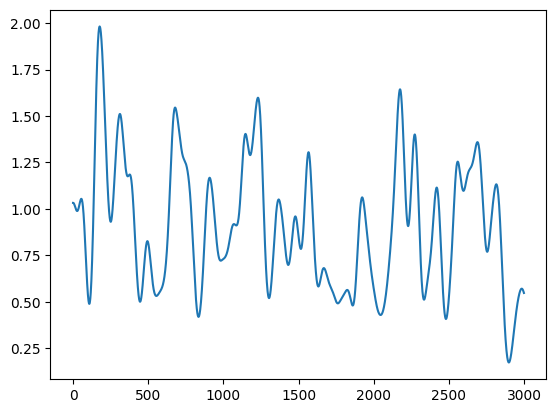

In [1]:
import os, requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# quick way to get broadband power in time-varying windows
from scipy import signal

matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False



# DATA RETRIEVAL ================================================
fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

alldat = np.load(fname, allow_pickle=True)['dat']




# PRE-PROCESSING ================================================
# pick subject 0 and experiment 0 (real movements)
data = alldat[0][0]

# V is the voltage data
V = data['V'].astype('double')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)





# Shaping ================================================
training_data = torch.zeros((60, 1, 3000)) #### CHANGE

# for channel in range(np.shape(V)[1]):  #### CHANGE
for channel in range(1):
  voltage_data = V[:, channel]
  t_on = data['t_on']      # Get the stimulus onset time
  t_off = data['t_off']    # Get the stimulus offset time
  srate = data['srate']    # Get the acquisition rate

  sequence_per_onset = torch.zeros((60, 3000))
  for i in range(len(t_on)):
    sequence_per_onset[i, :] = torch.from_numpy(voltage_data[t_on[i]:t_off[i]])
  training_data[:, channel, :] = sequence_per_onset

# (60, 1, 3000)
print(np.shape(training_data)) # 60 stimulus (rows) and 3000Hz long data / 1000 sampling rate = 3 seconds of stimulus each
# plt.figure(figsize=(20, 10))
# for j in range(20):
#   ax = plt.subplot(5, 10, j+1)
#   plt.plot(training_data[1, j, :])
#   plt.xticks([0, 1500, 3000])
#   plt.title('ch%d'%j)
# plt.show()

plt.plot(training_data[0, 0, :]) # plot 1





# Helper methods ================================================
LAMBDA_GP = 10
BATCH_SIZE = 60

def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose2d, nn.BatchNorm1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 1
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def gradient_penalty(D, real, fake):
    channel = 1
    sequence_length = 3000

    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, channel, sequence_length)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.start = nn.ConvTranspose1d(100, 50, kernel_size=9, stride=1, padding=4)
        self.end = nn.Linear(50 * 64, 3000)
        self.relu = nn.LeakyReLU(0.5)
        self.upsample = nn.Upsample(scale_factor=2)
        self.block = nn.Sequential(
            nn.ConvTranspose1d(50, 50, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(50, affine=True),
            nn.ReLU(),
            nn.ConvTranspose1d(50, 50, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(50, affine=True),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.start(x)
        x = self.relu(x)
        x = self.block(x)
        x = self.upsample(x)
        x = self.block(x)
        x = self.upsample(x)
        x = self.block(x)
        x = self.upsample(x)
        x = self.block(x)
        x = self.upsample(x)
        x = self.block(x)
        x = self.upsample(x)
        x = self.block(x)
        x = self.upsample(x)
        x = self.block(x)
        x = x.view(60, -1) # flatten
        x = self.end(x)
        return x.reshape(60, 1, 3000)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.start = nn.Conv1d(1, 50, kernel_size=9, stride=1, padding=4)
        self.end = nn.Linear(50 * 11, 1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.downsample = nn.AvgPool1d(kernel_size=2, stride=2)
        self.block = nn.Sequential(
            nn.Conv1d(50, 50, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(50, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv1d(50, 50, kernel_size=9, stride=1, padding=4),
            nn.InstanceNorm1d(50, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = x.float()
        x = self.start(x)
        x = self.lrelu(x)
        x = self.block(x)
        x = self.downsample(x)
        x = self.block(x)
        x = self.downsample(x)
        x = self.block(x)
        x = self.downsample(x)
        x = self.block(x)
        x = self.downsample(x)
        x = self.block(x)
        x = self.downsample(x)
        x = self.block(x)
        x = self.downsample(x)
        x = self.block(x)
        x = self.downsample(x)
        x = self.block(x)
        x = self.downsample(x)
        x = x.view(60, -1) # flatten
        x = self.end(x)
        return x.reshape(60)

def train():
    num_epochs = 500
    print_interval = 50
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(num_epochs):
        for d_index in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(60, 100, 1)
            fake = G(noise)
            critic_real = D(real).reshape(-1) # flatten
            critic_fake = D(fake).reshape(-1) # flatten
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % print_interval == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data, disc, gen = train()

# save your models
torch.save(gen, 'gen.pt')
torch.save(disc, 'disc.pt')

# load your models
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

Epoch 0: Critic error ([6.1913065910339355]) Generator err ([-0.5162063241004944])
Epoch 50: Critic error ([6.1913065910339355, 3.991887092590332, 3.1240439414978027, 3.2687771320343018, 2.4356887340545654, 2.574097156524658, 1.996421456336975, 1.7015470266342163, 1.3033326864242554, 1.358240008354187, 0.8184243440628052, 0.7630926370620728, 0.8077876567840576, 0.6420645713806152, 0.4602193236351013, 0.42822274565696716, 0.3643755316734314, 0.2489999532699585, 0.3183768093585968, 0.28956839442253113, -0.14573191106319427, -0.05172574520111084, -0.14136773347854614, -0.10094067454338074, -0.29013893008232117, -0.4143059253692627, -0.5905277729034424, -0.5285804867744446, -0.3070876896381378, -0.35157161951065063, -0.4336547255516052, -0.6321091055870056, -0.8773807883262634, -0.9955323934555054, -1.0845805406570435, -0.9641098976135254, -0.5242286324501038, -0.43086105585098267, -0.5687692761421204, -0.3794715106487274, -0.5173635482788086, -0.6556648015975952, -0.7472072243690491, -0.7

Epoch 200: Critic error ([6.1913065910339355, 3.991887092590332, 3.1240439414978027, 3.2687771320343018, 2.4356887340545654, 2.574097156524658, 1.996421456336975, 1.7015470266342163, 1.3033326864242554, 1.358240008354187, 0.8184243440628052, 0.7630926370620728, 0.8077876567840576, 0.6420645713806152, 0.4602193236351013, 0.42822274565696716, 0.3643755316734314, 0.2489999532699585, 0.3183768093585968, 0.28956839442253113, -0.14573191106319427, -0.05172574520111084, -0.14136773347854614, -0.10094067454338074, -0.29013893008232117, -0.4143059253692627, -0.5905277729034424, -0.5285804867744446, -0.3070876896381378, -0.35157161951065063, -0.4336547255516052, -0.6321091055870056, -0.8773807883262634, -0.9955323934555054, -1.0845805406570435, -0.9641098976135254, -0.5242286324501038, -0.43086105585098267, -0.5687692761421204, -0.3794715106487274, -0.5173635482788086, -0.6556648015975952, -0.7472072243690491, -0.7346392273902893, -0.6693374514579773, -0.8816581964492798, -1.1470601558685303, -1

Epoch 300: Critic error ([6.1913065910339355, 3.991887092590332, 3.1240439414978027, 3.2687771320343018, 2.4356887340545654, 2.574097156524658, 1.996421456336975, 1.7015470266342163, 1.3033326864242554, 1.358240008354187, 0.8184243440628052, 0.7630926370620728, 0.8077876567840576, 0.6420645713806152, 0.4602193236351013, 0.42822274565696716, 0.3643755316734314, 0.2489999532699585, 0.3183768093585968, 0.28956839442253113, -0.14573191106319427, -0.05172574520111084, -0.14136773347854614, -0.10094067454338074, -0.29013893008232117, -0.4143059253692627, -0.5905277729034424, -0.5285804867744446, -0.3070876896381378, -0.35157161951065063, -0.4336547255516052, -0.6321091055870056, -0.8773807883262634, -0.9955323934555054, -1.0845805406570435, -0.9641098976135254, -0.5242286324501038, -0.43086105585098267, -0.5687692761421204, -0.3794715106487274, -0.5173635482788086, -0.6556648015975952, -0.7472072243690491, -0.7346392273902893, -0.6693374514579773, -0.8816581964492798, -1.1470601558685303, -1

Epoch 350: Critic error ([6.1913065910339355, 3.991887092590332, 3.1240439414978027, 3.2687771320343018, 2.4356887340545654, 2.574097156524658, 1.996421456336975, 1.7015470266342163, 1.3033326864242554, 1.358240008354187, 0.8184243440628052, 0.7630926370620728, 0.8077876567840576, 0.6420645713806152, 0.4602193236351013, 0.42822274565696716, 0.3643755316734314, 0.2489999532699585, 0.3183768093585968, 0.28956839442253113, -0.14573191106319427, -0.05172574520111084, -0.14136773347854614, -0.10094067454338074, -0.29013893008232117, -0.4143059253692627, -0.5905277729034424, -0.5285804867744446, -0.3070876896381378, -0.35157161951065063, -0.4336547255516052, -0.6321091055870056, -0.8773807883262634, -0.9955323934555054, -1.0845805406570435, -0.9641098976135254, -0.5242286324501038, -0.43086105585098267, -0.5687692761421204, -0.3794715106487274, -0.5173635482788086, -0.6556648015975952, -0.7472072243690491, -0.7346392273902893, -0.6693374514579773, -0.8816581964492798, -1.1470601558685303, -1

Epoch 400: Critic error ([6.1913065910339355, 3.991887092590332, 3.1240439414978027, 3.2687771320343018, 2.4356887340545654, 2.574097156524658, 1.996421456336975, 1.7015470266342163, 1.3033326864242554, 1.358240008354187, 0.8184243440628052, 0.7630926370620728, 0.8077876567840576, 0.6420645713806152, 0.4602193236351013, 0.42822274565696716, 0.3643755316734314, 0.2489999532699585, 0.3183768093585968, 0.28956839442253113, -0.14573191106319427, -0.05172574520111084, -0.14136773347854614, -0.10094067454338074, -0.29013893008232117, -0.4143059253692627, -0.5905277729034424, -0.5285804867744446, -0.3070876896381378, -0.35157161951065063, -0.4336547255516052, -0.6321091055870056, -0.8773807883262634, -0.9955323934555054, -1.0845805406570435, -0.9641098976135254, -0.5242286324501038, -0.43086105585098267, -0.5687692761421204, -0.3794715106487274, -0.5173635482788086, -0.6556648015975952, -0.7472072243690491, -0.7346392273902893, -0.6693374514579773, -0.8816581964492798, -1.1470601558685303, -1

Epoch 450: Critic error ([6.1913065910339355, 3.991887092590332, 3.1240439414978027, 3.2687771320343018, 2.4356887340545654, 2.574097156524658, 1.996421456336975, 1.7015470266342163, 1.3033326864242554, 1.358240008354187, 0.8184243440628052, 0.7630926370620728, 0.8077876567840576, 0.6420645713806152, 0.4602193236351013, 0.42822274565696716, 0.3643755316734314, 0.2489999532699585, 0.3183768093585968, 0.28956839442253113, -0.14573191106319427, -0.05172574520111084, -0.14136773347854614, -0.10094067454338074, -0.29013893008232117, -0.4143059253692627, -0.5905277729034424, -0.5285804867744446, -0.3070876896381378, -0.35157161951065063, -0.4336547255516052, -0.6321091055870056, -0.8773807883262634, -0.9955323934555054, -1.0845805406570435, -0.9641098976135254, -0.5242286324501038, -0.43086105585098267, -0.5687692761421204, -0.3794715106487274, -0.5173635482788086, -0.6556648015975952, -0.7472072243690491, -0.7346392273902893, -0.6693374514579773, -0.8816581964492798, -1.1470601558685303, -1

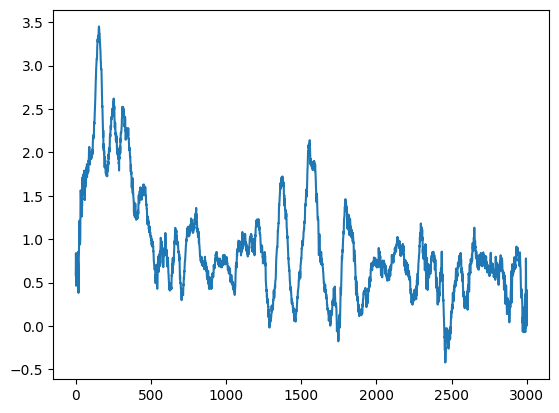

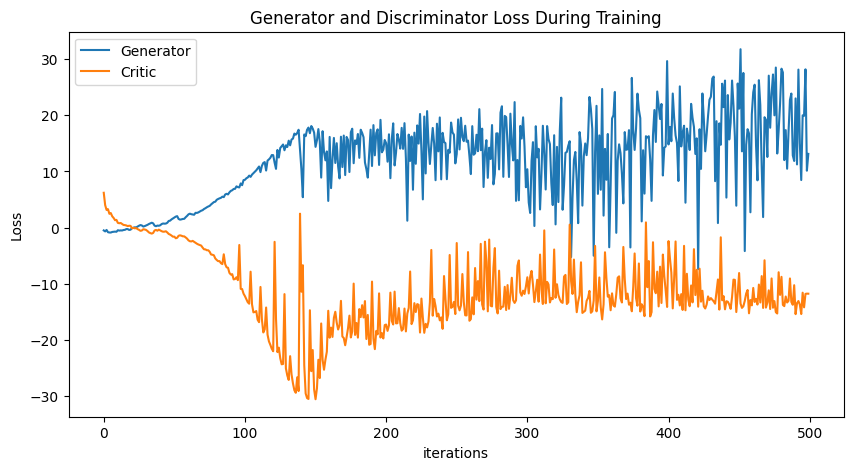

In [8]:
# generated data
values = generated_data[1, :, :]
plt.plot(values.tolist()[0])

# plotting G vs D losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_err,label="Generator")
plt.plot(critic_err,label="Critic")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
data = generated_data.detach().numpy()

# save your generated data
# np.save('josh_output.npy', data)

# load yout generated data
# loaded_tensor = np.load('josh_output.npy')

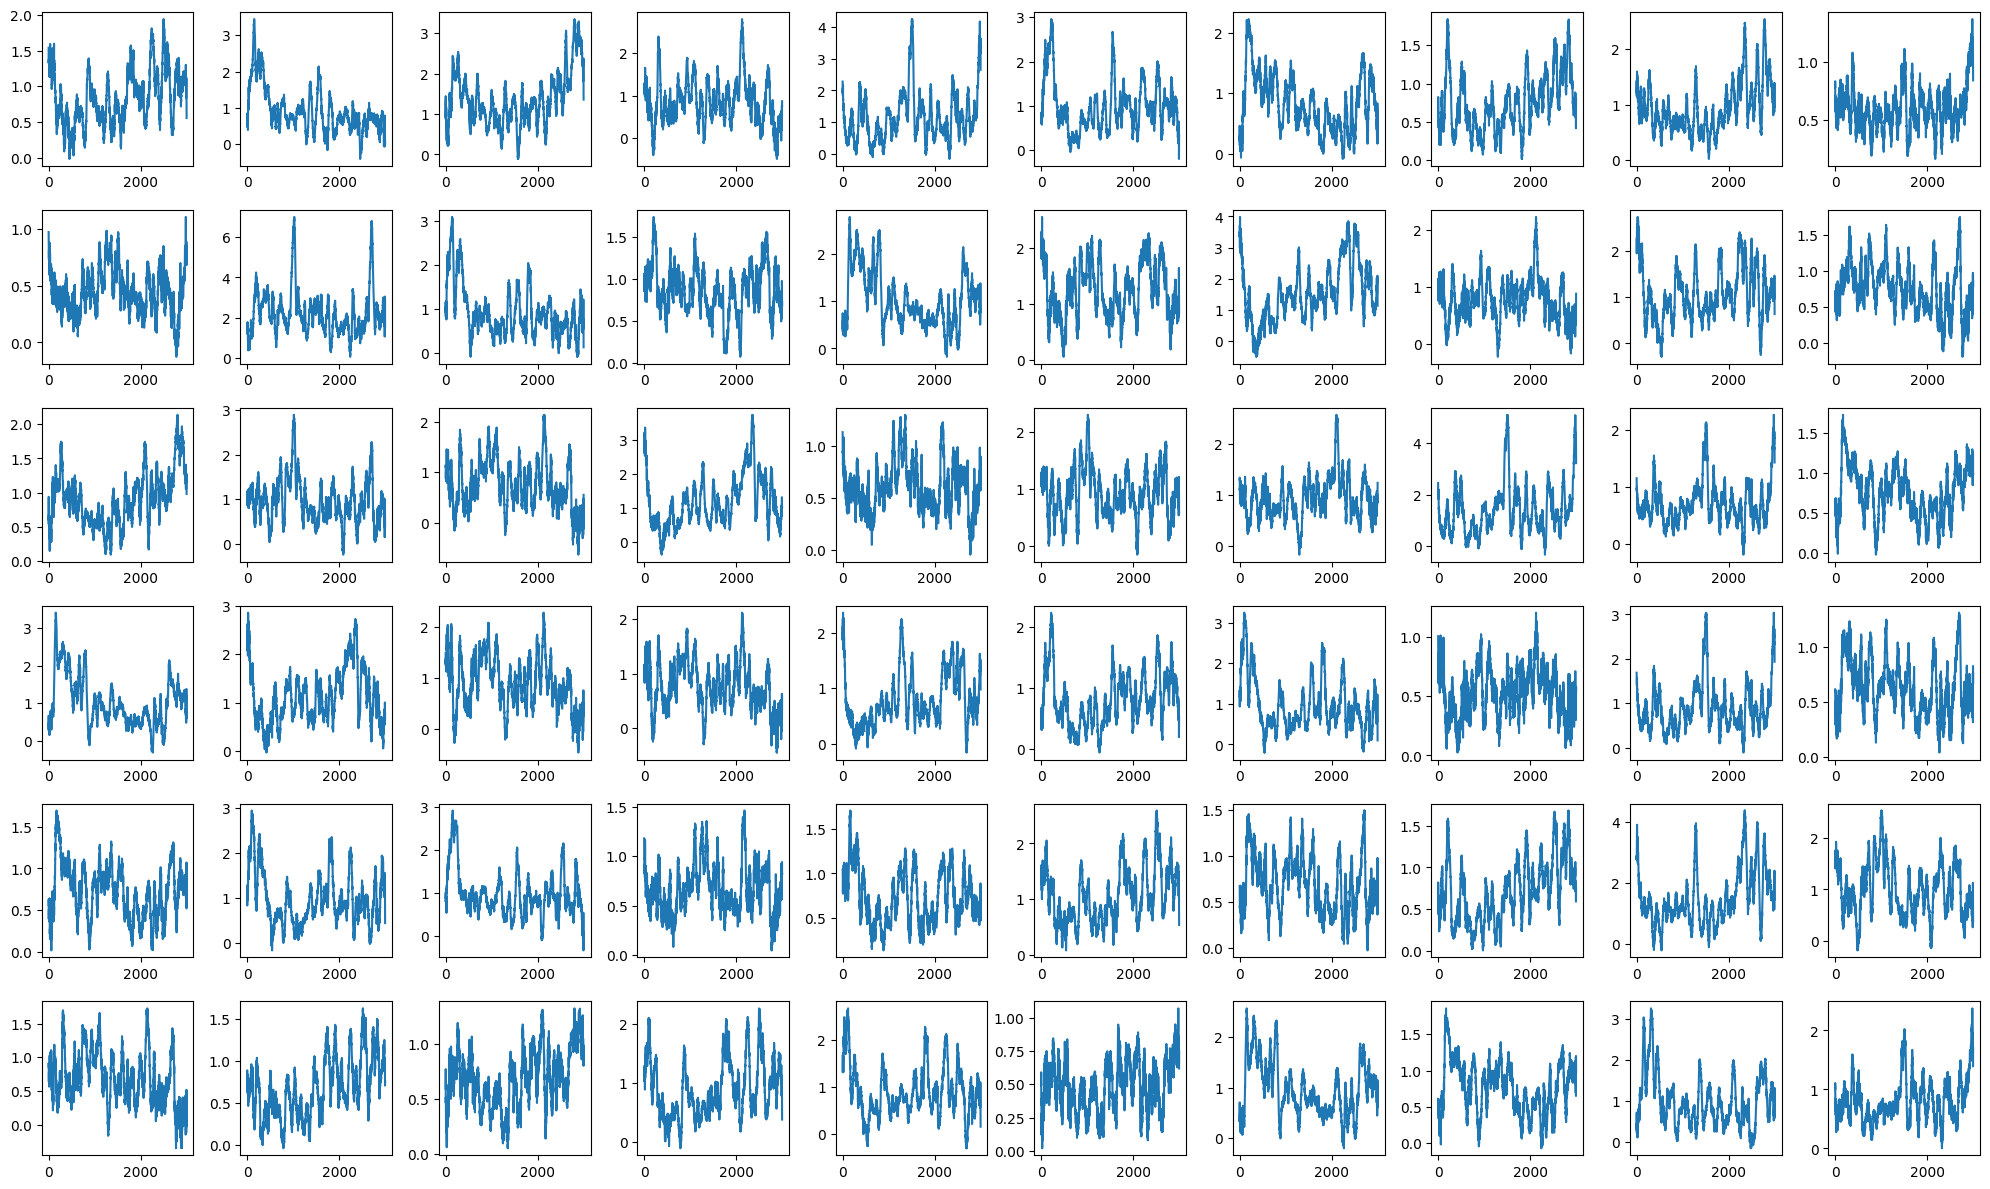

In [23]:
num_plots = 60
num_rows = 6
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))

for i, ax in enumerate(axes.flatten()):
    y = generated_data[i, :, :]
    ax.plot(y.tolist()[0])
plt.tight_layout()
plt.show()


(60, 1, 3000)